In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import _linear
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle

from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

In [2]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'w')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'r')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)    

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [3]:
#different
offset = 20000
valid_size = 10000
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99350000 n in the February 1934 riots, anarchists divided over a 'united 
10000 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana


In [4]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))


Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [5]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

[u'n in the Fe', u".\n* ''[[Con", u"oldier's so", u'\xf6hm-Bawerk ', u'tification,', u' warrior, a', u'uot; would ', u' 115       ', u'orbata acid', u'>\n      <co', u'ate, the co', u'other natio', u'ing the his', u'et bromine;', u' Christ&quo', u' average]] ', u' their home', u'ks and a ri', u'on]]/[[Joel', u' new era fo', u'aph that th', u' known as t', u's from the ', u'ast majorit', u'trips, thou', u'ent of regi', u'metric aspe', u'd named by ', u'Z</timestam', u'tude of 1 c', u'!&quot; [ht', u'o ==\n\n* [[D', u'[[Belarusia', u'iton]], Rus', u'ccessful si', u'es his theo', u' explain th', u' the South.', u'sing with a', u'd ball is h', u'e could des', u'[Friedrich ', u'th virtuall', u' foreign ac', u'variant in ', u'd and watch', u"t; ''[[Foot", u' became Lea', u'stern Europ', u' </contribu', u'ese terms n', u'arting in t', u'gence of th', u'of the cons', u'uickly swit', u', thus star', u'lly develop', u'g the offic', u'esult, the ', u'red HMMWV. ', u'ament is de', u'University ', 

In [6]:

class regular_swap(MODEL):
    def layer(self, 
              inp_t,
              state_t_minus_1,
              memory_t_minus_1):
        X_t = tf.concat(1, [inp_t,
                            state_t_minus_1,
                            memory_t_minus_1])
        RES = tf.matmul(X_t, self.Matrix) + self.Bias
        state_t = tf.tanh(RES)
        return state_t

    
    def swap_iteration(self, inp, state, counter):
        counter_update = tf.assign_add(counter, tf.constant(1, dtype=tf.int32))
        with tf.control_dependencies([counter_update]):
            swap = tf.equal(counter, tf.constant(self._swap_frequency))        
        [memory, counter_update] = tf.cond(swap,
                                           lambda: [state[0], counter.assign(tf.constant(0, dtype=tf.int32))],
                                           lambda: [state[1], counter])
        
        with tf.control_dependencies([counter_update, memory]):
            self.compare_memory_and_outputs = tf.equal(memory, state[0])
            output = self.layer(inp,
                                state[0],
                                memory)
        return output, [output, memory], swap, [counter_update]
    
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_layers,
                 num_nodes,
                 swap_frequency,
                 train_text,
                 valid_text,
                 seed=None,
                 mean=0.,
                 stddev='default',
                 shift=0.,
                 init_learning_rate=1.):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        self._num_unrollings = num_unrollings
        self._num_layers = num_layers
        self._num_nodes = num_nodes
        self._swap_frequency = swap_frequency
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        
        self._mean = mean
        
        self._stddev = list()
        if stddev == 'default':
            self._stddev = 1.0 * np.sqrt(1./(num_nodes[0] + vocabulary_size))
        else:
            self._stddev = stddev 
        self._shift = shift
        self._init_learning_rate = init_learning_rate
        
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "half_life": 4,
                         "decay": 5,
                         "num_steps": 6,
                         "averaging_number": 7,
                         "swap_frequency":8,
                         "init_mean": 9,
                         "init_stddev": 10,
                         "init_shift": 11,
                         "init_learning_rate": 12,
                         "type": 13}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                if seed is not None:
                    tf.set_random_seed(random.randint(-2*10**9, 2*10**9))
                self.Matrix = tf.Variable(tf.truncated_normal([self._vocabulary_size + 2*self._num_nodes[0],
                                                               self._num_nodes[0]],
                                                              mean=self._mean,
                                                              stddev=self._stddev))
                self.Bias = tf.Variable([self._shift for _ in range(self._num_nodes[0])])

                # classifier 
                weights = tf.Variable(tf.truncated_normal([self._num_nodes[-1], self._vocabulary_size], stddev = 0.1))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                """swap frequency""" 
                self._freq = tf.constant(self._swap_frequency, dtype=tf.int32)
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.

                saved_state = [tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False),
                               tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False)]
                
                """global step"""
                self._global_step = tf.Variable(0)
                
                self.compare_memory_and_outputs = 0

                outputs = list()
                swaps = list()
                state = saved_state
                """counter after swap"""
                self.counter = tf.Variable(0, trainable=True)
                counter_update = [self.counter]
                for inp in train_inputs:
                    with tf.control_dependencies(counter_update):
                        output, state, swap, counter_update = self.swap_iteration(inp, state, self.counter)
                        outputs.append(output)
                        swaps.append(swap)
                self.swaps = tf.pack(swaps)

                save_list = list()
                save_list.append(saved_state[0].assign(state[0]))
                save_list.append(saved_state[1].assign(state[1]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)

                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(tf.concat(0, outputs), weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits, tf.concat(0, train_labels)))
                # Optimizer.
                
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(self._init_learning_rate,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                gradients, v = zip(*optimizer.compute_gradients(self._loss))
                gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                """optimizer"""
                self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)

                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])
                
                """counter after swap"""
                sample_counter = tf.Variable(0, trainable=True)
                counter_update = [sample_counter]
                
                reset_list = list()
                reset_list.append(saved_sample_state[0].assign(tf.zeros([1, self._num_nodes[0]])))
                reset_list.append(saved_sample_state[1].assign(tf.zeros([1, self._num_nodes[0]])))
                reset_list.append(sample_counter.assign(tf.constant(0, dtype=tf.int32)))

                """reset sample state"""
                self._reset_sample_state = tf.group(*reset_list)
                
                """counter after swap"""
                sample_counter = tf.Variable(0, trainable=True)
                sample_counter_update = [sample_counter]
                
                with tf.control_dependencies(sample_counter_update):
                    sample_output, sample_state, _, sample_counter_update = self.swap_iteration(self._sample_input, saved_sample_state, sample_counter)


                sample_save_list = list()
                sample_save_list.append(saved_sample_state[0].assign(sample_state[0]))
                sample_save_list.append(saved_sample_state[1].assign(sample_state[1]))

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._num_layers)
        metadata.append(self._num_nodes)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append(self._swap_frequency)
        metadata.append(self._mean)
        metadata.append(self._stddev)
        metadata.append(self._shift)
        metadata.append(self._init_learning_rate)
        metadata.append('regular_swap')
        return metadata

In [9]:
model = regular_swap(64,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 10,
                 1,
                 [128],
                     9,
                 train_text,
                 valid_text)

In [12]:
fuse_texts = [u'my name is', u'december elegy', u'they have done']
model.run(30,
          0.9,
            200,
            50,
            3,
            1,
            20,
            print_intermediate_results = True,
          fuse_texts=fuse_texts,
          add_operation = 'self.counter')

Initialized
0   self.counter = 1
Average loss at step 0: 5.281623 learning rate: 1.000000
Percentage_of correct: 0.00%

random:
bÄ-_ÍS¹{!WbíÔaP×É)ZïÆçhº#ß.0Ò´&5þ	bÆ.·pf^!î­"ø8bßp$åMÌº$ÑjR^üc­ ­«1¶ºÞó´b±Wppà÷©
M©G>»Tûì I]G*Ûø?ÖI>.¦Ü¿ÏíçX'fewïkw®ôósIÐM^o^v[åî9¯û¤ªþgJÙªÏ¢aiKû}ìãÚPÚ« ø(j +
:-ôÚ[öaÝhwÍñÔYc'C@Q»UÉ¢3.È"añéÄõAØR? Î]ÕÜ§¿zþÊ¯­Ñ¥}¶Cý8WåÎB20S	g¢dW59=»%`u)=¸2ù
Bú¶v`o9ítoKCôµ`ÓE\qVÆÅÖQiÙäUSÉÑúæSîe¦D(³'	*¡49éPh_ï.q°8å%øF ]=VDÛ;[Äïál³¦NÕyYL»
Ùúí¦«hµÖO·×d0¹_ÿ/ý^MLéiVÌÌüü y})ªåGFs~ª0åÊbd¿ú²-ÚÄ¸RÅgÝúp1%,l/6¿	§ `bí³Á[ÀÓ^Á¸nü

from fuse:
0. fuse: my name is
my name isç¡4æäV|t(Ìû	àñçç
ð¹Ñ;+¹dóë	md}E¿÷9'XÞ¼x·ä}PÒu`Ø6qIxFøc¾R°Ëm¢G»]Xí¥ÌÞÂú~Ô¨ËNÈnÚ
1. fuse: december elegy
december elegy×¼¿]Ùø/m÷JÃh)0 JbúëO~¬itm]Ï~rä(Ê+Û½)øõ+t¨ó¯à}FGÊ¥n«Ä"Qo¡~v®y¼I~½ñfÞ®¼×?Råg>:sT
2. fuse: they have done
they have doneÓ}>Õóî<6ào½>-úGÚwUè×?Lq>m/ÞtÛ=ÚÙÞQ¡ á¬íþ¯)>rUsî;;gCi#þ	³úzK< nxTh#çsPYÿþ= ñ­S°ý
Validation percentage of correct: 12.84%

1   self.counter = 2
2   self.counter = 3
3   self.counter = 4
4   

KeyboardInterrupt: 

In [7]:

swap_values = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]
iter_num = 5
results_GL = list()
counter = 0    
for swap_value in swap_values:
    print("swap: ", swap_value)
    model = regular_swap(64,
                             vocabulary,
                             characters_positions_in_vocabulary,
                             30,
                             1,
                             [128],
                             swap_value,
                             train_text,
                             valid_text)
    model.simple_run(200,
                         'regular_swap/variables/1_128_ns20000_stairs_30_ilr_1._nu_30sw%s' % (swap_value),
                            20000,
                               4000,
                               5000,        #learning has a chance to be stopped after every block of steps
                               30,
                               0.9,
                               3,
                    fixed_num_steps=True)
    results_GL.extend(model._results)
    model.destroy()
    del model
    counter += 1
        

swap:  1
Number of steps = 20000     Percentage = 47.68%     Time = 569s     Learning rate = 0.0424
swap:  2
Number of steps = 20000     Percentage = 47.27%     Time = 491s     Learning rate = 0.0424
swap:  3
Number of steps = 20000     Percentage = 47.34%     Time = 494s     Learning rate = 0.0424
swap:  4
Number of steps = 20000     Percentage = 47.23%     Time = 486s     Learning rate = 0.0424
swap:  5
Number of steps = 20000     Percentage = 47.28%     Time = 485s     Learning rate = 0.0424
swap:  6
Number of steps = 20000     Percentage = 47.13%     Time = 486s     Learning rate = 0.0424
swap:  7
Number of steps = 20000     Percentage = 47.32%     Time = 487s     Learning rate = 0.0424
swap:  8
Number of steps = 20000     Percentage = 47.34%     Time = 496s     Learning rate = 0.0424
swap:  10
Number of steps = 20000     Percentage = 47.33%     Time = 487s     Learning rate = 0.0424
swap:  11
Number of steps = 20000     Percentage = 47.13%     Time = 488s     Learning rate = 0.042

In [8]:
folder_name = 'regular_swap'
file_name = 'second_regular_swap_ns_20000_hl_667_dc_0.9_nu_30_sw1-15.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling regular_swap/second_regular_swap_ns_20000_hl_667_dc_0.9_nu_30_sw1-15.pickle.


In [28]:
folder_name = 'regular_swap'
pickle_file = 'second_regular_swap_ns_20000_hl_667_dc_0.9_nu_30_sw1-15.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [29]:
folder_name = 'regular_swap'
pickle_file = 'regular_swap_ns_100000_hl_1428_dc_0.9_swap_1_30.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results2_GL = save['results_GL']
  del save  # hint to help gc free up memory

results_GL.extend(results2_GL)

In [37]:
print(len(results_GL))

48


In [10]:
from plot_module import ComparePlots

regular_swap_plots = ComparePlots('regular_swap')
regular_swap_plots.add_network(results_GL, model._indices)



{'layout_variable': None, 'fixed': None, 'data': [{'y': [47.68098958333332, 47.27161458333334, 47.337760416666654, 47.228125000000006, 47.27812499999999, 47.128385416666625, 47.31588541666665, 47.34270833333335, 47.33020833333331, 47.12578124999998, 47.27447916666668, 47.14791666666666, 47.33307291666665, 47.19348958333334], 'x': [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15], 'layout_value': None}], 'x_variable': ('swap_frequency', None), 'several_networks': False}
There is no labels on plot


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


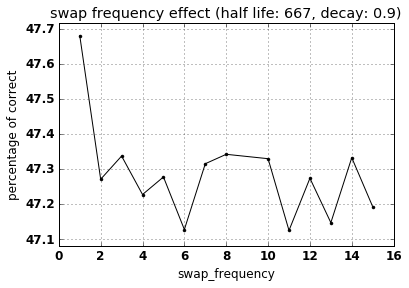

In [11]:
plot_data, _ = regular_swap_plots.one_key_layout_data('regular_swap_1',
                                         'swap_frequency',
                                         None,
                                                     averaging=False)
print(plot_data[0])
regular_swap_plots.save_layout(plot_data[0],
                    'swap frequency effect (half life: 667, decay: 0.9)',
                    ['swap_frequency_effect', 'plots'],
                    'nn128;ns20000;hl667;dc0.9',
                              continious=[True])
regular_swap_plots.draw(plot_data[0], 'swap frequency effect (half life: 667, decay: 0.9)',
                       continious=[True])

In [2]:
a=u'абвгдежз'
print(str(a))

UnicodeEncodeError: 'ascii' codec can't encode characters in position 0-7: ordinal not in range(128)